In [10]:
import json
import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans, DBSCAN

pd.set_option('mode.chained_assignment', None)

class CloudSchematic:
    def __init__(self, vertices:np.ndarray):
        
        self.vertices = vertices
        self.df = pd.DataFrame(vertices, columns=["x","y","z"]).sort_values("z")
        
        self.min_z, self.max_z = self.df["z"].agg([min,max])
        self.height = round(self.max_z - self.min_z, 2)
        tenth = self.height / 10
        self.z_bounds_low = [self.min_z +tenth *i for i in range(10)]
        self.z_bounds_high = [self.min_z +tenth *(i+1) for i in range(10)]
        
        vert_counts = [
            len(self.df[self.df["z"].apply(lambda x: self.z_bounds_low[i] < x < self.z_bounds_high[i])])
            for i in range(1, 9)
        ]
        optimal_slice_idx = np.argmin(vert_counts) + 1 # ??? and +(-)
        bounds = (optimal_slice_idx *10, (optimal_slice_idx +1) *10)
        
        self._slice = slice(len(self.df)//100*bounds[0], len(self.df)//100*bounds[1])
        self.data = self.df.iloc[self._slice].drop(columns="z")
        
        mean_x, mean_y = self.df.iloc[self._slice]["x"].mean(), self.df.iloc[self._slice]["y"].mean()
        self.data["distance"] = self.data.apply(lambda a: 
            ((mean_x - a["x"])**2 + (mean_y - a["y"])**2)**.5, axis=1)
        self.radius = round(self.data["distance"].mean(), 2)
        self.ratio = self.height /(self.radius *2)
        
    
    @classmethod
    def calc_circle_points(cls, n_points=32, radius=1, origin=(0,0)):
        vertices = []
        delta = 2 * math.pi / n_points 
        theta = 0.0
        for i in range(n_points):
            theta += delta
            if len(origin)==2:
                vertices.append((
                    origin[0] + radius * math.cos(theta),
                    origin[1] + radius * math.sin(theta)))
            else:
                vertices.append((
                    origin[0] + radius * math.cos(theta),
                    origin[1] + radius * math.sin(theta),
                    origin[2]))

        return np.array(vertices)
        
    def generate(self, draw_plot=True): 
        sub_df = self.df[self.df["z"].apply(lambda x: 
            self.z_bounds_low[0] < x < self.z_bounds_high[0])]
        centroids = KMeans(n_clusters=6).fit(sub_df[["x", "y"]]).cluster_centers_
        fit_x, fit_y = centroids[:,0].mean(), centroids[:,1].mean()
        self.center_point_bottom = np.array([fit_x, fit_y, self.min_z])

        sub_df = self.df[self.df["z"].apply(lambda x: 
            self.z_bounds_low[-1] < x < self.z_bounds_high[-1])]
        centroids = KMeans(n_clusters=6).fit(sub_df[["x", "y"]]).cluster_centers_
        fit_x, fit_y = centroids[:,0].mean(), centroids[:,1].mean()
        self.center_point_top = np.array([fit_x, fit_y, self.max_z])

        self.circle_points_bottom = CloudSchematic.calc_circle_points(
            radius=self.radius, origin=self.center_point_bottom)
        self.circle_points_top = CloudSchematic.calc_circle_points(
            radius=self.radius, origin=self.center_point_top)
        
        if draw_plot:
            fig = plt.figure(figsize=(20/self.ratio, 20))
            ax = fig.add_subplot(111, projection='3d')

            ax.scatter(self.df["x"], self.df["y"], self.df["z"], alpha=.01)

            ax.scatter(*self.center_point_bottom, c="r")
            ax.scatter(*self.center_point_top, c="r")
            ax.plot(*list(zip(self.center_point_bottom, self.center_point_top)), c="r")
            middle = (np.array(self.center_point_bottom) +np.array(self.center_point_top)) /2
            ax.text(*middle, f"Height: {self.height}m", size=16)
            ax.plot(*list(zip(self.center_point_bottom, self.circle_points_bottom[-1,:])), c="r")
            ax.plot(*list(zip(self.center_point_top, self.circle_points_top[-1,:])), c="r")
            middle = (np.array(self.center_point_top) +np.array(self.circle_points_top[-1,:])) /2
            ax.text(*middle, f"Radius: {self.radius}m", size=16)

            ax.scatter(
                list(self.circle_points_bottom[:,0]),
                list(self.circle_points_bottom[:,1]),
                list(self.circle_points_bottom[:,2]), c="r")
            ax.scatter(
                list(self.circle_points_top[:,0]),
                list(self.circle_points_top[:,1]),
                list(self.circle_points_top[:,2]), c="r")
            
    def project_shaft(self):
        fig, ax = plt.subplots(figsize=(6, 20))
        for c in self.cylinders:
            base_left_front = c.bottom[15][[0,2]]
            base_right_front = c.bottom[-1][[0,2]]
            top_left_front = c.top[15][[0,2]]
            top_right_front = c.top[-1][[0,2]]
            ax.plot(*list(zip(base_left_front, base_right_front)), c="b")
            ax.plot(*list(zip(top_left_front, top_right_front)), c="r")
            ax.plot(*list(zip(base_left_front, top_left_front)), c="k")
            ax.plot(*list(zip(base_right_front, top_right_front)), c="k")
            ax.text(0, c.origin + c.height /2, f"height= {int(round(c.height, 1) *100)}cm", size=20)
            ax.text(base_left_front[0], c.origin, f"diameter= {int(round(c.radius *2, 1) *100)}cm", size=20)
        return fig, ax
        
    def project(self):
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
        [ax[i][ii].set_axis_off() for i in range(2) for ii in range(2)]
            
        base_left_front = self.circle_points_bottom[15][[0,2]]
        base_right_front = self.circle_points_bottom[-1][[0,2]]
        top_left_front = self.circle_points_top[15][[0,2]]
        top_right_front = self.circle_points_top[-1][[0,2]]
        ax[0][0].plot(*list(zip(base_left_front, base_right_front)), c="b")
        ax[0][0].plot(*list(zip(top_left_front, top_right_front)), c="r")
        ax[0][0].plot(*list(zip(base_left_front, top_left_front)), c="k")
        ax[0][0].plot(*list(zip(base_right_front, top_right_front)), c="k")

        base_left_side = self.circle_points_bottom[7][[1,2]]
        base_right_side = self.circle_points_bottom[23][[1,2]]
        top_left_side = self.circle_points_top[7][[1,2]]
        top_right_side = self.circle_points_top[23][[1,2]]
        ax[0][1].plot(*list(zip(base_left_side, base_right_side)), c="b")
        ax[0][1].plot(*list(zip(top_left_side, top_right_side)), c="r")
        ax[0][1].plot(*list(zip(base_left_side, top_left_side)), c="k")
        ax[0][1].plot(*list(zip(base_right_side, top_right_side)), c="k")
        
        ax[1][0].scatter(*list(zip(*self.circle_points_bottom[:,[0,1]])), c="b")     
        ax[1][0].scatter(*self.center_point_bottom[:2], c="b")
        ax[1][0].plot([self.center_point_bottom[0], self.circle_points_bottom[-1][0]], 
                 [self.center_point_bottom[1], self.circle_points_bottom[-1][1]], "b")
        ax[1][0].scatter(*list(zip(*self.circle_points_top[:,[0,1]])), c="r")
        ax[1][0].scatter(*self.center_point_top[:2], c="r")
        ax[1][0].plot([self.center_point_top[0], self.circle_points_top[-1][0]], 
                 [self.center_point_top[1], self.circle_points_top[-1][1]], "r")
        
        ax[1][1].text(.4,.5, "Info\ngoes\nhere", size=20)
        
        
        transFigure = fig.transFigure.inverted()
        
        coord1 = transFigure.transform(ax[0][0].transData.transform([*base_right_front]))
        coord2 = transFigure.transform(ax[0][1].transData.transform([*base_left_side]))
        line = matplotlib.lines.Line2D(
            (coord1[0],coord2[0]),
            (coord1[1],coord2[1]),
            transform=fig.transFigure,
            linestyle="dashed", color="b")
        
        coord1 = transFigure.transform(ax[0][0].transData.transform([*top_right_front]))
        coord2 = transFigure.transform(ax[0][1].transData.transform([*top_left_side]))
        line2 = matplotlib.lines.Line2D(
            (coord1[0],coord2[0]),
            (coord1[1],coord2[1]),
            transform=fig.transFigure,
            linestyle="dashed", color="r")
        
        coord1 = transFigure.transform(ax[0][0].transData.transform([*base_right_front]))
        coord2 = transFigure.transform(ax[1][0].transData.transform([*self.circle_points_bottom[-1][[0,1]]]))
        line3 = matplotlib.lines.Line2D(
            (coord1[0],coord2[0]),
            (coord1[1],coord2[1]),
            transform=fig.transFigure,
            linestyle="dashed", color="b")
        
        coord1 = transFigure.transform(ax[0][0].transData.transform([*base_left_front]))
        coord2 = transFigure.transform(ax[1][0].transData.transform([*self.circle_points_bottom[15][[0,1]]]))
        line4 = matplotlib.lines.Line2D(
            (coord1[0],coord2[0]),
            (coord1[1],coord2[1]),
            transform=fig.transFigure,
            linestyle="dashed", color="b")
        
        coord1 = transFigure.transform(ax[0][0].transData.transform([*top_right_front]))
        coord2 = transFigure.transform(ax[1][0].transData.transform([*self.circle_points_top[-1][[0,1]]]))
        line5 = matplotlib.lines.Line2D(
            (coord1[0],coord2[0]),
            (coord1[1],coord2[1]),
            transform=fig.transFigure,
            linestyle="dashed", color="r")
        
        coord1 = transFigure.transform(ax[0][0].transData.transform([*top_left_front]))
        coord2 = transFigure.transform(ax[1][0].transData.transform([*self.circle_points_top[15][[0,1]]]))
        line6 = matplotlib.lines.Line2D(
            (coord1[0],coord2[0]),
            (coord1[1],coord2[1]),
            transform=fig.transFigure,
            linestyle="dashed", color="r")
        
        fig.lines = [line, line2, line3, line4, line5, line6]
        
    def shaft_circles(self):
        circles=[]
        self.cylinders = []
        for seg in self.z_bounds:
            df = self.df[self.df["z"].apply(lambda a: seg[0] < a < seg[1])]
            seg_min_z, seg_max_z = df["z"].agg([min,max])
            seg_height = round(seg_max_z - seg_min_z, 2)
            tenth = seg_height / 10
            z_bounds_low = [seg_min_z +tenth *i for i in range(10)]
            z_bounds_high = [seg_min_z +tenth *(i+1) for i in range(10)]

            vert_counts = [
                len(df[df["z"].apply(lambda x: z_bounds_low[i] < x < z_bounds_high[i])])
                for i in range(1, 9)
            ]
            optimal_slice_idx = np.argmin(vert_counts) + 1 # ??? and +(-)
            bounds = (optimal_slice_idx *10, (optimal_slice_idx +1) *10)

            _slice = slice(len(df)//100*bounds[0], len(df)//100*bounds[1])
            df = df.iloc[_slice]

            mean_x, mean_y = df["x"].mean(), df["y"].mean()
            df["distance"] = df.apply(lambda a: ((mean_x - a["x"])**2 + (mean_y - a["y"])**2)**.5, axis=1)
            radius = round(df["distance"].mean(), 2)
            
            centroids = KMeans(n_clusters=6).fit(df[["x", "y"]]).cluster_centers_
            fit_x, fit_y = centroids[:,0].mean(), centroids[:,1].mean()
            
            circles.append(CloudSchematic.calc_circle_points(radius=radius, origin=(fit_x, fit_y, seg_min_z)))
            circles.append(CloudSchematic.calc_circle_points(radius=radius, origin=(fit_x, fit_y, seg_max_z)))
            
            cylinder = Cylinder(
                center = (fit_x, fit_y),
                origin = seg_min_z,
                radius = radius, height=seg_height, 
                top = circles[-1], bottom=circles[-2])
            self.cylinders.append(cylinder)
            
        return circles
        
    def cross_section(self):
        self.df["zz"] = self.df["z"].apply(lambda a: round(a, 2))
        radii = dict(self.df.groupby("zz").agg([min, max])["x"].apply(lambda x: x["max"] -x["min"], axis=1))

        df = pd.DataFrame()
        df["z"] = list(radii.keys()) 
        df["rad"] = list(radii.values())
        df["label"] = dbscan = list(DBSCAN(eps=.01).fit_predict(np.array(df["rad"]).reshape(-1,1)))
        df.drop(df[df["label"]==-1].index, inplace=True) # Dropped Noise

        dfs = []
        for lab in df["label"].unique():
            sub_df = df[df["label"] == lab]
            sub_df["label"] = list(DBSCAN(eps=.1).fit_predict(np.array(sub_df["z"]).reshape(-1,1)))

            main_clst = sorted(dict(sub_df["label"].value_counts()).items(),
                               key=lambda i:i[1], reverse=True)[0][0]

            sub_df.drop(sub_df[sub_df["label"] != main_clst].index, inplace=True)
            sub_df["label"] = [lab for i in range(len(sub_df))]
            dfs.append(sub_df)

        df = pd.concat(dfs)
        self.z_bounds = [df[df["label"]==lab]["z"].min() for lab in df["label"].unique()] + [df["z"].max()]
        self.z_bounds = [(self.z_bounds[i], self.z_bounds[i+1]) for i, _ in enumerate(self.z_bounds[:-1])]
        
        plt.figure(figsize=(15,3))
        plt.scatter(data=df, x="z", y="rad", c="label")
        
        plt.vlines(df[df["label"]==0]["z"].min(), 0, 1.2)
        plt.vlines(df[df["label"]==1]["z"].min(), 0, 1.2)
        plt.vlines(df[df["label"]==2]["z"].min(), 0, 1.2)
        plt.hlines(round(np.mean(df[df["label"]==0]["rad"]), 1), -2.25, 0)
        plt.hlines(round(np.mean(df[df["label"]==1]["rad"]), 1), -2.25, 0)
        plt.hlines(round(np.mean(df[df["label"]==2]["rad"]), 1), -2.25, 0)
        plt.vlines(df["z"].max(), 0, 1.2)

        plt.show()
        
        
        self.df.drop(columns="zz", inplace=True)

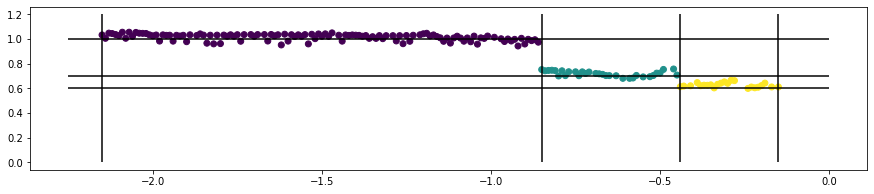

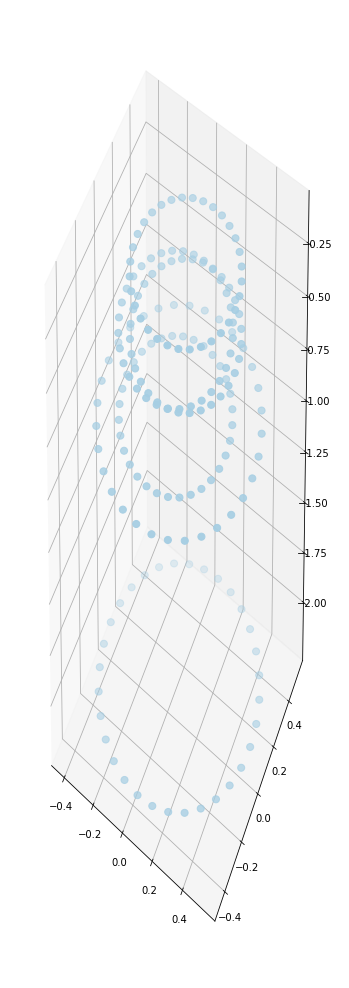

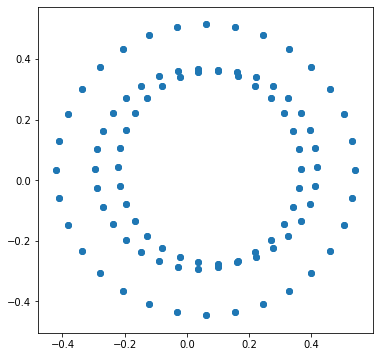

In [11]:
with open("cylinder_SEG.json", "r") as file:
    cs = CloudSchematic(json.load(file))
cs.generate(draw_plot=False)
cs.cross_section()
circle_points = np.concatenate(cs.shaft_circles())

min_z = circle_points[:,2].min()
max_z = circle_points[:,2].max()
normalize = lambda n: (n - min_z) / (max_z / min_z)
color = list(map(lambda m: cm.Paired(m[2]), circle_points))

fig = plt.figure(figsize=(6,6*cs.ratio))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(xs=np.array(cs.vertices)[:,0], ys=np.array(cs.vertices)[:,1], zs=np.array(cs.vertices)[:,2], s=.1, c="g")
ax.scatter(xs=circle_points[:,0], ys=circle_points[:,1], zs=circle_points[:,2], c=color, s=50)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(x=circle_points[:,0], y=circle_points[:,1])
plt.show()

In [2]:
class Cylinder():
    def __init__(self, center, origin, radius, height, top, bottom, *kwargs):
        self.center = center
        self.origin = origin
        self.radius = radius
        self.height = height
        self.top = top
        self.bottom = bottom
        
        self.ratio = self.height / self.radius

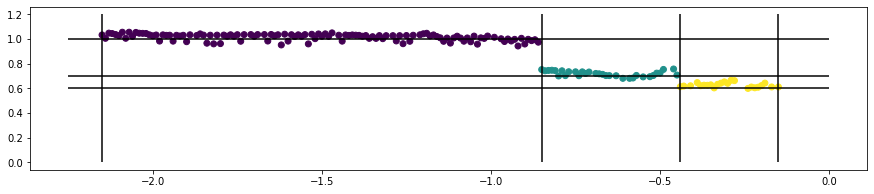

/home/becode/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


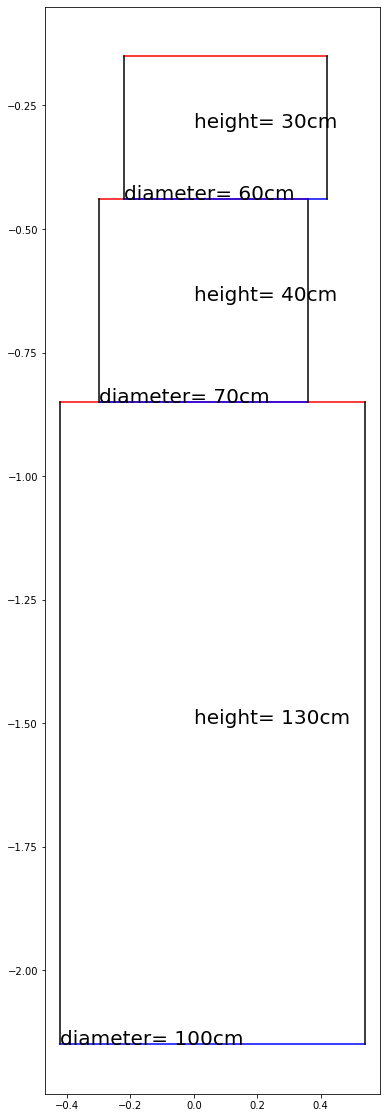

In [4]:
with open("cylinder_SEG.json", "r") as file:
    cs = CloudSchematic(json.load(file))
cs.generate(draw_plot=False)
cs.cross_section()
cs.shaft_circles()
fig, ax = cs.project_shaft()
fig.show()

In [4]:
import matplotlib.cm as cmap

In [64]:
cmap.viridis

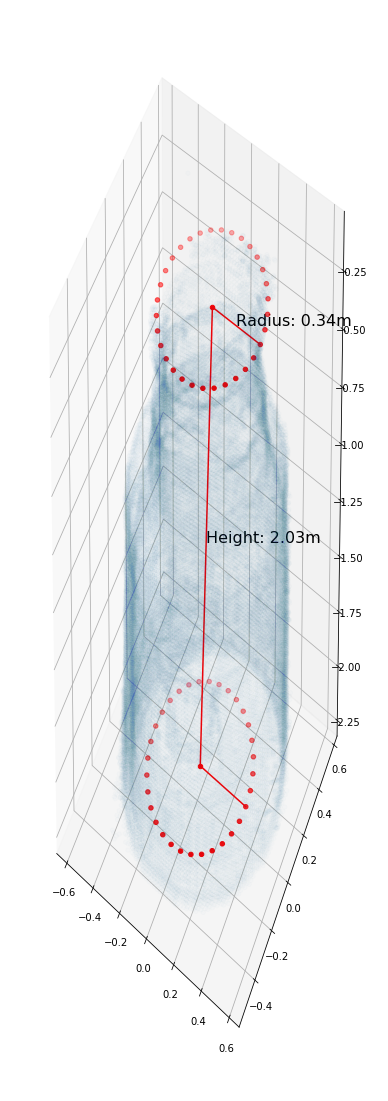

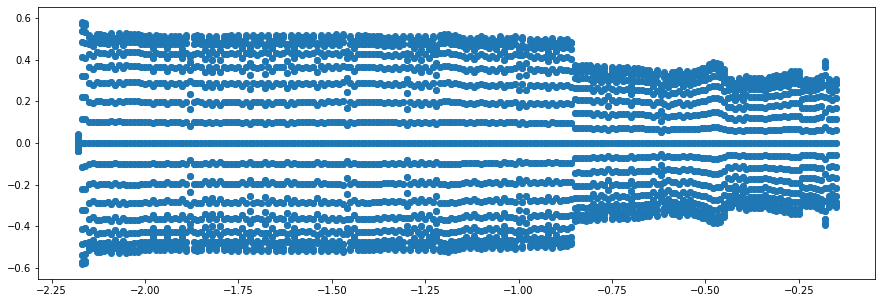

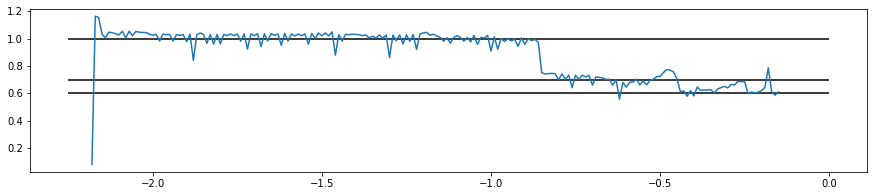

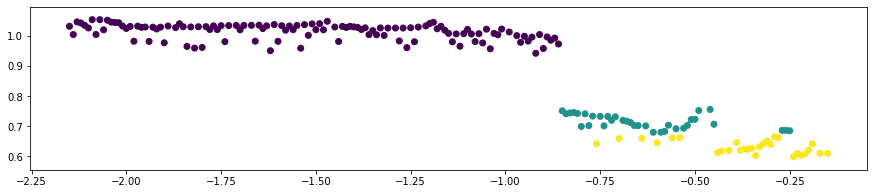

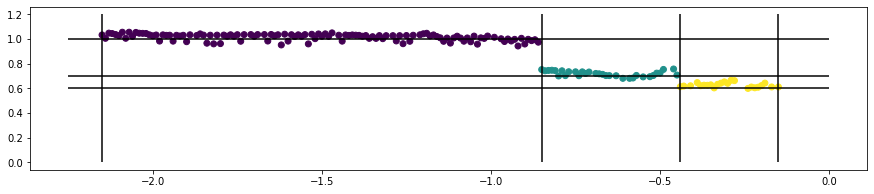

0    32
Name: label, dtype: int64


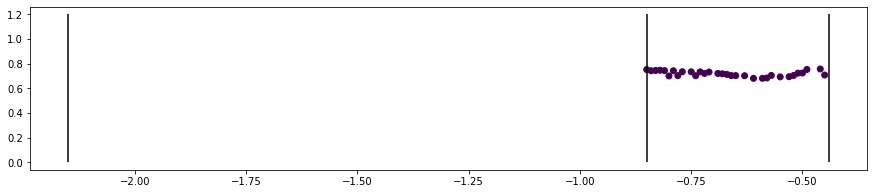

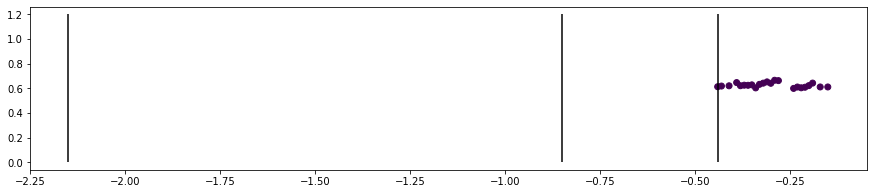

(array([-1,  0]), array([ 2, 21]))
0.6257834408594214


In [18]:
with open("cylinder_SEG.json", "r") as file:
    cs = CloudSchematic(json.load(file))
cs.generate(draw_plot=True)

cs.df["zz"] = cs.df["z"].apply(lambda a: round(a, 2))
radii = cs.df.groupby("zz").agg([min, max])["x"].apply(lambda x: x["max"] -x["min"], axis=1)
circles = list(map(lambda z_val: CloudSchematic.calc_circle_points(radius=z_val[1]/2,  origin=(0, 0, z_val[0])), radii.items()))

#plt.figure(figsize=(6*cs.ratio, 6))
plt.figure(figsize=(15,5))
#plt.scatter(data=cs.df, x="y", y="z")
plt.scatter(y=np.concatenate(circles)[:,0], x=np.concatenate(circles)[:,2])
plt.show()

plt.figure(figsize=(15,3))
plt.plot(radii)
plt.hlines(1, -2.25, 0)
plt.hlines(.6, -2.25, 0)
plt.hlines(.7, -2.25, 0)
plt.show()

cs.df["zz"] = cs.df["z"].apply(lambda a: round(a, 2))
radii = dict(cs.df.groupby("zz").agg([min, max])["x"].apply(lambda x: x["max"] -x["min"], axis=1))


df = pd.DataFrame()
df["z"] = list(radii.keys()) 
df["rad"] = list(radii.values())
df["label"] = dbscan = list(DBSCAN(eps=.01).fit_predict(np.array(df["rad"]).reshape(-1,1)))
df.drop(df[df["label"]==-1].index, inplace=True) # Dropped Noise

plt.figure(figsize=(15,3))
plt.scatter(data=df, x="z", y="rad", c="label")

dfs = []
for lab in df["label"].unique():
    sub_df = df[df["label"] == lab]
    sub_df["label"] = list(DBSCAN(eps=.1).fit_predict(np.array(sub_df["z"]).reshape(-1,1)))
    
    main_clst = sorted(dict(sub_df["label"].value_counts()).items(),
                       key=lambda i:i[1], reverse=True)[0][0]
    
    sub_df.drop(sub_df[sub_df["label"] != main_clst].index, inplace=True)
    sub_df["label"] = [lab for i in range(len(sub_df))]
    dfs.append(sub_df)

df = pd.concat(dfs)
plt.figure(figsize=(15,3))
plt.scatter(data=df, x="z", y="rad", c="label")

plt.vlines(df[df["label"]==0]["z"].min(), 0, 1.2)
plt.vlines(df[df["label"]==1]["z"].min(), 0, 1.2)
plt.vlines(df[df["label"]==2]["z"].min(), 0, 1.2)
plt.hlines(round(np.mean(df[df["label"]==0]["rad"]), 1), -2.25, 0)
plt.hlines(round(np.mean(df[df["label"]==1]["rad"]), 1), -2.25, 0)
plt.hlines(round(np.mean(df[df["label"]==2]["rad"]), 1), -2.25, 0)
plt.vlines(df["z"].max(), 0, 1.2)

plt.show()


sub_df = df[df["label"]==1]
sub_df["label"] = dbscan = DBSCAN(eps=.1).fit_predict(np.array(sub_df["z"]).reshape(-1,1))
print(sub_df["label"].value_counts())

plt.figure(figsize=(15,3))
plt.scatter(data=sub_df, x="z", y="rad", c="label")

plt.vlines(df[df["label"]==0]["z"].min(), 0, 1.2)
plt.vlines(df[df["label"]==1]["z"].min(), 0, 1.2)
plt.vlines(df[df["label"]==2]["z"].min(), 0, 1.2)
plt.show()

#for lab in labels
sub_df = df[df["label"]==2]
sub_df["label"] = dbscan = DBSCAN(eps=.1).fit_predict(np.array(sub_df["z"]).reshape(-1,1))
main_clst = sorted(dict(zip(*np.unique(dbscan, return_counts=True))).items(),
                  key=lambda i:i[1], reverse=True)[0][0]
sub_df.drop(sub_df[sub_df["label"] != main_clst].index, inplace=True)

plt.figure(figsize=(15,3))
plt.scatter(data=sub_df, x="z", y="rad", c="label")

plt.vlines(df[df["label"]==0]["z"].min(), 0, 1.2)
plt.vlines(df[df["label"]==1]["z"].min(), 0, 1.2)
plt.vlines(df[df["label"]==2]["z"].min(), 0, 1.2)
plt.show()



print(np.unique(DBSCAN(eps=.009).fit_predict(
    np.array(df[df["label"] == lab]["rad"]).reshape(-1,1)), return_counts=True))
print(np.mean(df[df["label"] == lab]["rad"]))


#plt.figure(figsize=(15,3))
#segment = KMeans(n_clusters=3).fit_predict(np.array(radii).reshape(-1,1))
#plt.bar({k: segment[i] for i, k in enumerate(dict(radii))}.values(),
#       {k: segment[i] for i, k in enumerate(dict(radii))}.keys())
#plt.show()

#cs.project()
#cs.interactive(


In [19]:
from plyfile import PlyData, PlyElement

ply = PlyData.read("2020-08-13_10 10 32.006_529_quick.ply")
data = np.array([list(ply["vertex"][idx]) for idx,_ in enumerate(ply["vertex"])])
verts = data[:, :3]
color = data[:, 3:]

In [20]:
import swifter

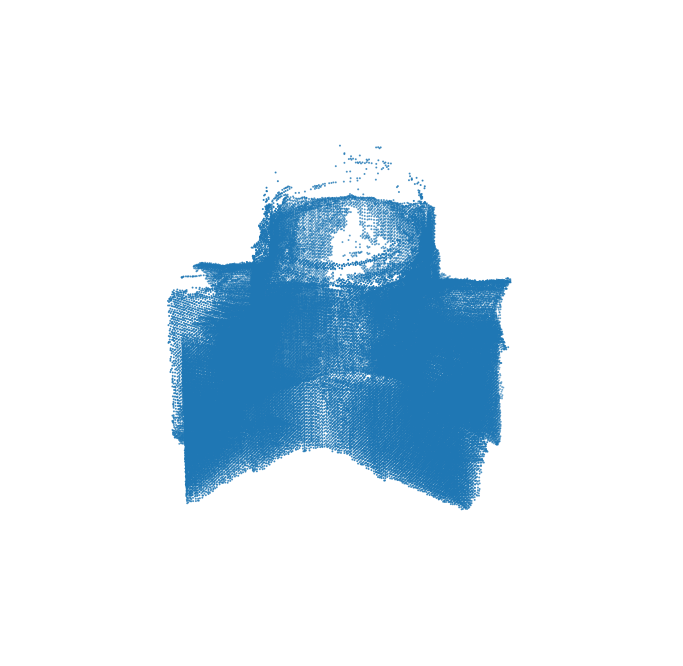

In [21]:
df = pd.DataFrame()
df["x"] = data[:, 0]
df["y"] = data[:, 1]
df["z"] = data[:, 2]

df["label"] = KMeans(n_clusters=3).fit_predict(color)
clst = sorted(dict(zip(*np.unique(df["label"], return_counts=True))).items(), key=lambda l: l[1])[::-1][0][0]
df_sub = df[df["label"].apply(lambda l: l == clst)]
df_sub.reset_index(inplace=True)

df_sub["label"] = DBSCAN(eps = .1).fit_predict(df_sub[["x","y","z"]])

clst = sorted(dict(zip(*np.unique(df_sub["label"], return_counts=True))).items(), key=lambda l: l[1])[::-1][0][0]

df_sub2 = df_sub[df_sub["label"].apply(lambda a:a == clst)]
df_sub2.reset_index(inplace=True)
df_sub2["label"] = DBSCAN(eps = .02).fit_predict(np.array(df_sub2["z"]).reshape(-1,1))

clst = sorted(dict(zip(*np.unique(df_sub2["label"], return_counts=True))).items(), key=lambda l: l[1])[::-1][0][0]

df_sub3 = df_sub2[df_sub2["label"].apply(lambda a:a == clst)]
np.unique(df_sub3["label"], return_counts=True)

df_sub3.reset_index(drop=True, inplace=True)


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_axis_off()
ax.scatter(df_sub3["x"], df_sub3["y"], df_sub3["z"], s=1)

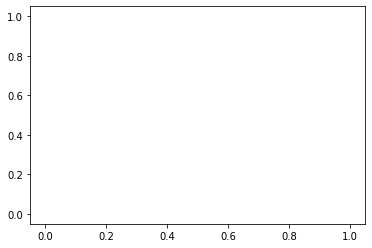

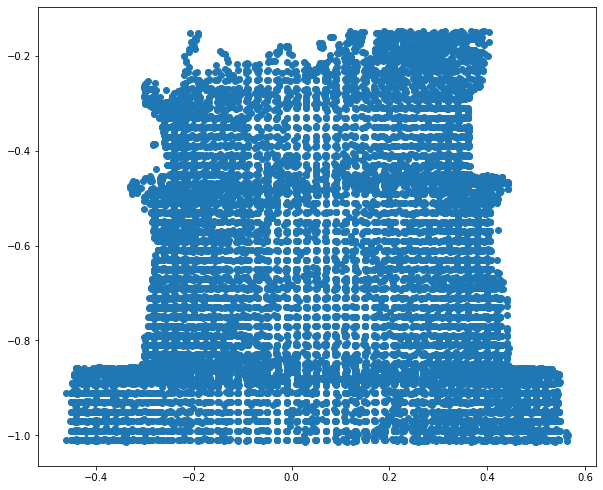

In [22]:
with open("cylinder_SEG.json","r") as file:
    data = np.array(json.load(file))

plt.plot()

df = pd.DataFrame()
df["x"] = data[:,0]
df["y"] = data[:,1]
df["z"] = data[:,2]

df["label"] = DBSCAN(eps=.05).fit_predict(df)
df = df[df["label"].apply(lambda x: x == df["label"].value_counts().idxmax())]

top, bottom = df["z"].max(), df["z"].min()
height = bottom -top

df.drop(df[df["z"].apply(lambda h: h < height/2)].index, inplace=True)

ax1_min, ax1_max = df["x"].min(), df["x"].max()
ax2_min, ax2_max = df["z"].min(), df["z"].max()
ratio = (ax2_max -ax2_min) / (ax1_max -ax1_min)

plt.figure(figsize=(10, 10*ratio))
plt.scatter(data=df, x="x", y="z")

In [ ]:
with open("large_test.json","r") as file:
    data = np.array(json.load(file))

df = pd.DataFrame()
df["x"] = data[:,0]
df["y"] = data[:,1]
df["z"] = data[:,2]

df["label"] = DBSCAN(eps=.05).fit_predict(df)
df = df[df["label"].apply(lambda x: x == df["label"].value_counts().idxmax())]

top, bottom = df["z"].max(), df["z"].min()
height = bottom -top

df.drop(df[df["z"].apply(lambda h: h < height/2)].index, inplace=True)

ax1_min, ax1_max = df["x"].min(), df["x"].max()
ax2_min, ax2_max = df["z"].min(), df["z"].max()
ratio = (ax2_max -ax2_min) / (ax1_max -ax1_min)

plt.figure(figsize=(10, 10*ratio))
plt.scatter(data=df, x="x", y="z")